In [143]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# prepare data

In [ ]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_new']
splits = ['test']
feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta)

# load model
p = 1
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
df = dfs[('clath_aux+gak_new', 'test')]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

# segmentation

In [7]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

m = 40
xtrack_unnormalized = df[track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)


# sort things
print('acc', np.mean((preds > 0) == y))

acc 0.8246445497630331


In [8]:
# calculate all cd scores
cd_score_path = f'../data/outputs/all_cd_scores_clath_aux+gak_new_test.pkl'
if os.path.exists(cd_score_path):
    all_cd_scores = pd.read_pickle(cd_score_path)
else:
    all_cd_scores = {}
    for s in tqdm(range(m)):
        for e in range(s+1, m+1):
            all_cd_scores[(s, e)] = interpret.calc_cd_score(xtrack_t, xfeats_t, s, e, dnn.model)
    with open(cd_score_path, 'wb') as handle:
        pkl.dump(all_cd_scores, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [39]:
# find best segmentations
all_res = []
for i in range(len(x)):
    cd_scores_list = np.zeros((m, m))
    for s in (range(m)):
        for e in range(s + 1, m + 1):            
            cd_scores_list[s][e-1] = all_cd_scores[(s, e)][i]
    res, paths = interpret.max_abs_sum_seg(cd_scores_list, min_length=5)
    lt = np.sum(np.array(df[track_name_unnormalized].values[i]) != 0)
    #all_res.append(paths[lt-1])
    all_res.append(paths[m - 1])
    #print(res[lt-1], paths[lt-1])

# paths is a list of lists, where each list contains all the starting point for segments    
all_res = np.array(all_res)    
    
def extract_segs_and_scores(all_res, all_cd_scores, i):
    '''
    Params
    ------
    all_res: array_like
        list of list of starting points for all segments
    '''
    segs = [(all_res[i][j], all_res[i][j+1]) # converting starting points to list of (start, end) pairs
            for j in range(len(all_res[i]) - 1)
           ] + [(all_res[i][-1], 40)]
    scores = [all_cd_scores[(s, e)][i][0]
              for (s, e) in segs]
    return segs, scores


<ipython-input-39-36b8292aa96f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_res = np.array(all_res)


In [ ]:
for which_tracks in ['aux-', 'aux+', 'random']: # random, neg, pos
    C, R = 3, 5

    # calculate vabs
    scores_all = [extract_segs_and_scores(all_res, all_cd_scores, i)[1] for i in range(all_res.size)]
    vmax = max([max(x) for x in scores_all])
    vmin = min([min(x) for x in scores_all])
    vabs = max(abs(vmax), abs(vmin)) / 2 # note this /2 thresholds things

    plt.figure(dpi=150, figsize=(2 * C, 1 * R), facecolor='w')
    i = 0
    for r in range(0, R):
        for c in range(0, C):
            ax = plt.subplot(R, C, i + 1)
            if which_tracks == 'random':
                arg = np.random.permutation(np.arange(n))
            elif which_tracks == 'aux-':
                arg = np.arange(n)
            elif which_tracks == 'aux+':
                arg = np.arange(n)[::-1]
            segs, scores = extract_segs_and_scores(all_res, all_cd_scores, arg[i])
        #     print('scores', segs, scores, preds[arg][i])
            interpret.plot_segs(track_segs=segs,
                                cd_scores=scores,
                                xtrack=xtrack_unnormalized.iloc[arg[i]],
        #                         pred=preds[arg][i],
        #                         y=y[arg][i],
                                vabs=vabs,
                                cbar=False,
                                xticks=(c==0 and r==R-1),
                                yticks=i==0)
            if which_tracks in ['aux+', 'random']:
                plt.ylim((-100, 10000))
            else:
                plt.ylim((-100, 2000))
            plt.suptitle(which_tracks + ' predictions')
            i += 1
    plt.tight_layout()
    viz.savefig('interpretations_' + which_tracks)
plt.show()

../src/viz.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(oj(DIR_FIGS, 'fig_' + s + '.pdf'))
/system/linux/anaconda3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


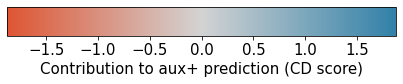

In [124]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
cmap = LinearSegmentedColormap.from_list(
        name='orange-blue', 
        colors=[(222/255, 85/255, 51/255),
                'lightgray',
                (50/255, 129/255, 168/255)]
    )
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                    norm=matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs),
                               cmap=cmap)
cb.ax.set_xlabel('Contribution to aux+ prediction (CD score)')
viz.savefig('interpretations_cbar')

**make simple illustrative plot**

In [ ]:
i = 98
plt.figure(figsize=(2.4, 1.9), facecolor='w', dpi=300)
segs, scores = extract_segs_and_scores(all_res, all_cd_scores, i)
cb = interpret.plot_segs(track_segs=segs, cd_scores=scores, xtrack=xtrack_unnormalized.iloc[i])
cb.set_ticks([])
plt.yticks([])
plt.xticks([])
plt.show()
#               pred=dnn.predict(x)[i],
#               y=y.values[i])

**recalculate with normalized scores (there is some err here)**

In [ ]:
all_cd_scores_normalized = {}
for s in tqdm(range(m)):
    for e in range(s + 1, m + 1):
        x = all_cd_scores[(s, e)]
        x = x.reshape(1, -1)[0]
        all_cd_scores_normalized[(s, e)] = np.abs((x - np.mean(x)) / np.std(x))
        
for i in range(len(df)):
    cd_scores_list = np.zeros((m, m))
    s0, e0 = 0, 0
    m = 0
    lt = np.sum(np.array(df[track_name_unnormalized].values[i]) != 0)
    for s in (range(lt)):
        for e in range(s+1, lt):            
            cd_scores_list[s][e-1] = all_cd_scores_normalized[(s, e)][i]
            if cd_scores_list[s][e-1] > m:
                m = cd_scores_list[s][e-1]
                s0, e0 = s, e

In [244]:
with open(f'results/all_cd_scores_clath_aux+gak_new_test.pkl', 'wb') as handle:
    pkl.dump(all_cd_scores, handle, protocol=pkl.HIGHEST_PROTOCOL)

# interpret one pred at multiple scales

In [5]:
def plot_segs(track_segs, cd_scores, xtrack, pred):
    cm = sns.diverging_palette(22, 220, as_cmap=True, center='light')
    vabs = np.max(np.abs(cd_scores))
    # plt.plot(xtrack, zorder=0, lw=2, color='#111111')
    for i in range(len(track_segs)):
        (s, e) = track_segs[i]
        cd_score = cd_scores[i]
        seq_len = e - s
        xs = np.arange(s, e)
        norm = matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
        if seq_len > 1:
            cd_score = [cd_score] * seq_len
            plt.plot(xs, xtrack[s: e], zorder=0, lw=2, color=cm(norm(cd_score[0])), alpha=0.5)
        plt.scatter(xs, xtrack[s: e],
                    c=cd_score, cmap=cm, vmin=-vabs, vmax=vabs, s=6)

In [10]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
num = 100
x = X.iloc[num: num + 1]
xtrack_unnormalized = df.iloc[num: num + 1][track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)
pred = dnn.model(xtrack_t, xfeats_t).item()
#print(f'pred {pred:0.2f}')

In [8]:
T = 40 # seq len
# track_segs = [(s, s + 1) for s in range(T)]
DIV = 40
track_segs_fourty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]

DIV = 20
track_segs_twenty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 10
track_segs_tenths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 6
track_segs_fifths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 4
track_segs_quarters = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 1
track_segs_full = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
track_segs_list = [track_segs_fourty, track_segs_twenty, track_segs_tenths,
                   track_segs_fifths, track_segs_quarters, track_segs_full]
cd_scores_list = [[interpret.calc_cd_score(xtrack_t, xfeats_t, s, e, dnn.model)
                  for (s, e) in track_segs]
                  for track_segs in tqdm(track_segs_list)]


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


In [ ]:
plt.figure(dpi=200, figsize=(12, 6))
R, C = 2, 3
for i, track_segs in enumerate(track_segs_list):
    ax = plt.subplot(R, C, i + 1)
    cd_scores = cd_scores_list[i]
    interpret.plot_segs(track_segs, cd_scores, xtrack_unnormalized.iloc[0], pred, y=0)
    
    if i == C * (R - 1):
        plt.xlabel('Time')
    else:
        plt.xticks([])
    if i == 0:
        plt.ylabel('Clath Amplitude')
    else:
        plt.yticks([])
    if i  == C - 1:
        plt.colorbar(label='CD Score')
    else:
        plt.colorbar()
    if i ==  C * R - 1:
        plt.text(0.6, 0.9,
                 f'Pred: {pred:.2f}', fontsize='x-large', transform = ax.transAxes)
plt.tight_layout()
plt.show()